In [1]:
import keras
from keras import backend as K
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, ELU
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Input, LSTM, RepeatVector, Lambda,Bidirectional,CuDNNLSTM
from keras import regularizers
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import objectives
import numpy as np
import matplotlib.pyplot as plt
from keras.regularizers import l2

Using TensorFlow backend.


In [2]:
X_test_valid = np.load("X_test.npy")
y_test_valid = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

In [4]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test_valid.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test_valid.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 25, 1000)
Test data shape: (443, 25, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


# Stacked LSTM Model

## Train one Test one

windows number: 97
(237, 22, 1000)
x training shape after sliding: (237, 97, 880)
Train on 189 samples, validate on 48 samples
Epoch 1/10
189/189 [==============================] - 15s 80ms/step - loss: 54.3721 - acc: 0.2857 - val_loss: 54.0785 - val_acc: 0.2917
Epoch 2/10
189/189 [==============================] - 4s 22ms/step - loss: 53.6469 - acc: 0.5450 - val_loss: 53.6341 - val_acc: 0.3125
Epoch 3/10
189/189 [==============================] - 4s 22ms/step - loss: 52.9468 - acc: 0.7249 - val_loss: 53.1797 - val_acc: 0.3333
Epoch 4/10
189/189 [==============================] - 4s 23ms/step - loss: 52.2999 - acc: 0.8571 - val_loss: 52.7203 - val_acc: 0.4583
Epoch 5/10
189/189 [==============================] - 4s 23ms/step - loss: 51.7291 - acc: 0.9259 - val_loss: 52.2882 - val_acc: 0.4583
Epoch 6/10
189/189 [==============================] - 4s 23ms/step - loss: 51.1812 - acc: 0.9683 - val_loss: 51.8698 - val_acc: 0.4792
Epoch 7/10
189/189 [==============================] - 4s 23ms/

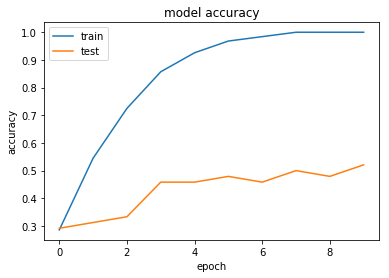

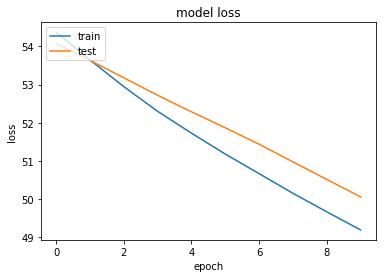

0.52
[[5. 3. 1. 3.]
 [0. 9. 1. 2.]
 [4. 2. 7. 1.]
 [3. 0. 4. 5.]]


In [18]:
def init_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(256,return_sequences=True,input_shape=input_shape, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(256,return_sequences=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(4,activation='softmax'))
    
    opt = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)   
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    return model


def train(model,x_train,y_train,x_test,y_test):
    history = model.fit(x_train,y_train,batch_size=50,epochs=10,shuffle=True,validation_split = 0.2)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return model
    
def predict(model,x_test,y_test):
    y_pred = model.predict(x_test)
    confusion_matrix = np.zeros((4, 4))
    accuracy = 0
    for i in range(y_pred.shape[0]):
        label_true = np.argmax(y_test[i])
        label_pred = np.argmax(y_pred[i])
        confusion_matrix[label_true, label_pred] += 1
        if label_true == label_pred:
            accuracy += 1
    accuracy /= x_test.shape[0]
    return accuracy,confusion_matrix

def get_sharded_data(data, indices_arr, indicator):
    indices = [i for i,x in enumerate(indices_arr) if x == indicator]
    return data[indices]


# Sliding windows on original data
window_length = 40
hop_length = 10
n_windows =(1000-window_length) // hop_length + 1 

print("windows number:", n_windows)


def sliding(data): #by default data's dimesnion is 3
    data_new = np.zeros((data.shape[0],n_windows,window_length*22)) #local variable
    for i in range(data.shape[0]):
        raw = data[i].transpose(1,0)
        for j in range(n_windows):
            data_new[i,j] = raw[j*hop_length:j*hop_length+window_length].flatten()
    return data_new


x_train = get_sharded_data(X_train_valid[:,:22,:],person_train_valid,0).astype('float32')
x_test = get_sharded_data(X_test[:,:22,:],person_test,0).astype('float32')
y_train = get_sharded_data(y_train_valid,person_train_valid,0)
y_test = get_sharded_data(y_test,person_test,0)

print(x_train.shape)
x_train = sliding(x_train)
x_test = sliding(x_test)
print("x training shape after sliding:",x_train.shape)

def RNN(x_train,y_train,x_test,y_test):
    train_example = x_train
    test_example = x_test
    train_target = keras.utils.to_categorical(y_train-769, 4)
    test_target = keras.utils.to_categorical(y_test-769, 4)
    
    model = init_model(train_example[0].shape)
    model = train(model,train_example,train_target,test_example,test_target)
    acc,c_matrix = predict(model,test_example,test_target)
    print(acc)
    print(c_matrix)

RNN(x_train,y_train,x_test,y_test)

## Train one Test one for all People

windows number: 199
person 0
(237, 199, 220)
Train on 189 samples, validate on 48 samples
Epoch 1/30
189/189 [==============================] - 13s 67ms/step - loss: 67.3401 - acc: 0.2698 - val_loss: 62.8848 - val_acc: 0.3542
Epoch 2/30
189/189 [==============================] - 3s 17ms/step - loss: 60.3134 - acc: 0.5820 - val_loss: 56.4579 - val_acc: 0.3958
Epoch 3/30
189/189 [==============================] - 3s 16ms/step - loss: 53.8599 - acc: 0.5926 - val_loss: 50.4519 - val_acc: 0.3333
Epoch 4/30
189/189 [==============================] - 3s 17ms/step - loss: 47.8526 - acc: 0.6720 - val_loss: 44.9551 - val_acc: 0.3750
Epoch 5/30
189/189 [==============================] - 3s 17ms/step - loss: 42.3758 - acc: 0.7884 - val_loss: 40.0334 - val_acc: 0.4167
Epoch 6/30
189/189 [==============================] - 3s 15ms/step - loss: 37.5133 - acc: 0.8307 - val_loss: 35.4784 - val_acc: 0.4792
Epoch 7/30
189/189 [==============================] - 3s 16ms/step - loss: 33.0638 - acc: 0.8889 - 

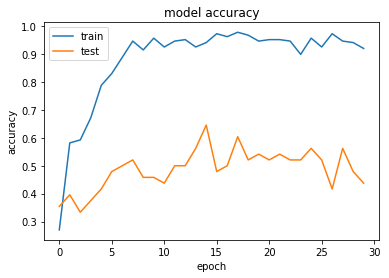

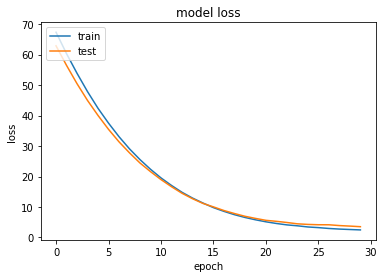

0.5
person 1
(236, 199, 220)
Train on 188 samples, validate on 48 samples
Epoch 1/30
188/188 [==============================] - 12s 65ms/step - loss: 67.1472 - acc: 0.2660 - val_loss: 62.3347 - val_acc: 0.4375
Epoch 2/30
188/188 [==============================] - 3s 18ms/step - loss: 59.7117 - acc: 0.4787 - val_loss: 55.3022 - val_acc: 0.3333
Epoch 3/30
188/188 [==============================] - 3s 15ms/step - loss: 52.8456 - acc: 0.5000 - val_loss: 48.9595 - val_acc: 0.3542
Epoch 4/30
188/188 [==============================] - 3s 15ms/step - loss: 46.5677 - acc: 0.5904 - val_loss: 43.2988 - val_acc: 0.3333
Epoch 5/30
188/188 [==============================] - 3s 15ms/step - loss: 40.8697 - acc: 0.7394 - val_loss: 38.3806 - val_acc: 0.3125
Epoch 6/30
188/188 [==============================] - 3s 15ms/step - loss: 36.0638 - acc: 0.7500 - val_loss: 33.9711 - val_acc: 0.2917
Epoch 7/30
188/188 [==============================] - 3s 15ms/step - loss: 31.6544 - acc: 0.8351 - val_loss: 30.033

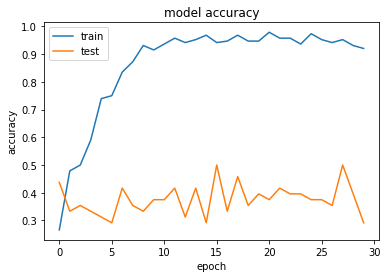

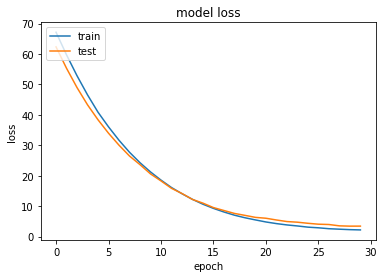

0.4
person 2
(236, 199, 220)
Train on 188 samples, validate on 48 samples
Epoch 1/30
188/188 [==============================] - 13s 69ms/step - loss: 67.1622 - acc: 0.2340 - val_loss: 62.4192 - val_acc: 0.3750
Epoch 2/30
188/188 [==============================] - 3s 15ms/step - loss: 59.8321 - acc: 0.4681 - val_loss: 55.6844 - val_acc: 0.3125
Epoch 3/30
188/188 [==============================] - 3s 16ms/step - loss: 52.9921 - acc: 0.6702 - val_loss: 49.3241 - val_acc: 0.3958
Epoch 4/30
188/188 [==============================] - 3s 15ms/step - loss: 46.6138 - acc: 0.8245 - val_loss: 43.7230 - val_acc: 0.4167
Epoch 5/30
188/188 [==============================] - 3s 15ms/step - loss: 41.1823 - acc: 0.7926 - val_loss: 38.7402 - val_acc: 0.3542
Epoch 6/30
188/188 [==============================] - 3s 15ms/step - loss: 36.1768 - acc: 0.8670 - val_loss: 34.2319 - val_acc: 0.3542
Epoch 7/30
188/188 [==============================] - 3s 15ms/step - loss: 31.7207 - acc: 0.9202 - val_loss: 30.218

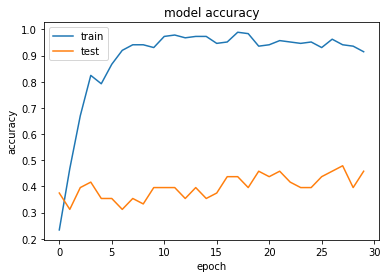

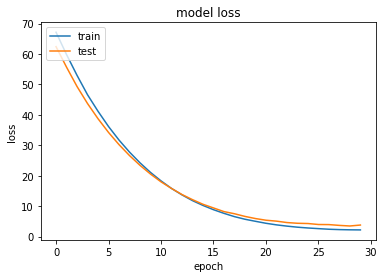

0.52
person 3
(234, 199, 220)
Train on 187 samples, validate on 47 samples
Epoch 1/30
187/187 [==============================] - 13s 72ms/step - loss: 67.0165 - acc: 0.2727 - val_loss: 62.2429 - val_acc: 0.1915
Epoch 2/30
187/187 [==============================] - 3s 16ms/step - loss: 59.4415 - acc: 0.4759 - val_loss: 54.9324 - val_acc: 0.3191
Epoch 3/30
187/187 [==============================] - 3s 15ms/step - loss: 52.3799 - acc: 0.5134 - val_loss: 48.4657 - val_acc: 0.3404
Epoch 4/30
187/187 [==============================] - 3s 15ms/step - loss: 45.9782 - acc: 0.5668 - val_loss: 42.6275 - val_acc: 0.3404
Epoch 5/30
187/187 [==============================] - 3s 15ms/step - loss: 40.2418 - acc: 0.6738 - val_loss: 37.4747 - val_acc: 0.4043
Epoch 6/30
187/187 [==============================] - 3s 14ms/step - loss: 35.2315 - acc: 0.7540 - val_loss: 33.0900 - val_acc: 0.3830
Epoch 7/30
187/187 [==============================] - 3s 15ms/step - loss: 30.8055 - acc: 0.8235 - val_loss: 29.03

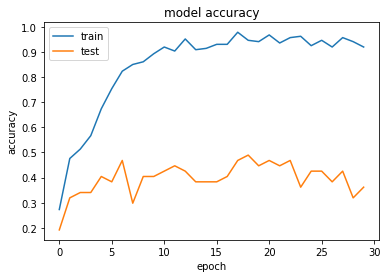

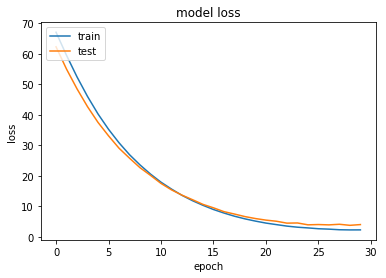

0.44
person 4
(235, 199, 220)
Train on 188 samples, validate on 47 samples
Epoch 1/30
188/188 [==============================] - 14s 74ms/step - loss: 67.1515 - acc: 0.2766 - val_loss: 62.3015 - val_acc: 0.2979
Epoch 2/30
188/188 [==============================] - 3s 14ms/step - loss: 59.6863 - acc: 0.4309 - val_loss: 55.3599 - val_acc: 0.3404
Epoch 3/30
188/188 [==============================] - 3s 14ms/step - loss: 52.9118 - acc: 0.5053 - val_loss: 49.1947 - val_acc: 0.3830
Epoch 4/30
188/188 [==============================] - 3s 14ms/step - loss: 46.5842 - acc: 0.6755 - val_loss: 43.6875 - val_acc: 0.3617
Epoch 5/30
188/188 [==============================] - 3s 14ms/step - loss: 41.0205 - acc: 0.7713 - val_loss: 38.5564 - val_acc: 0.4468
Epoch 6/30
188/188 [==============================] - 3s 15ms/step - loss: 36.1649 - acc: 0.8777 - val_loss: 34.2153 - val_acc: 0.3617
Epoch 7/30
188/188 [==============================] - 3s 14ms/step - loss: 31.8335 - acc: 0.8245 - val_loss: 30.14

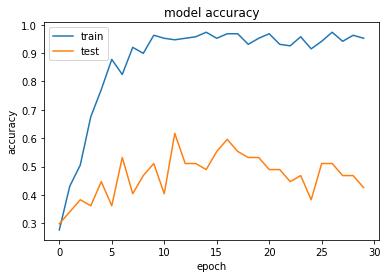

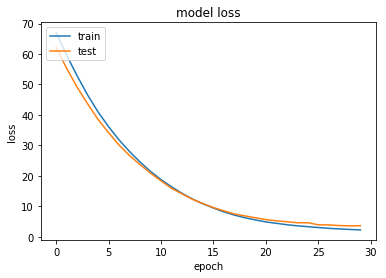

0.5319148936170213
person 5
(236, 199, 220)
Train on 188 samples, validate on 48 samples
Epoch 1/30
188/188 [==============================] - 14s 74ms/step - loss: 67.4380 - acc: 0.2606 - val_loss: 62.7673 - val_acc: 0.2917
Epoch 2/30
188/188 [==============================] - 3s 15ms/step - loss: 60.3252 - acc: 0.3617 - val_loss: 56.0474 - val_acc: 0.3542
Epoch 3/30
188/188 [==============================] - 3s 14ms/step - loss: 53.6904 - acc: 0.4521 - val_loss: 50.0447 - val_acc: 0.2917
Epoch 4/30
188/188 [==============================] - 3s 14ms/step - loss: 47.6302 - acc: 0.5798 - val_loss: 44.5738 - val_acc: 0.3333
Epoch 5/30
188/188 [==============================] - 3s 14ms/step - loss: 42.1191 - acc: 0.7447 - val_loss: 39.6001 - val_acc: 0.4583
Epoch 6/30
188/188 [==============================] - 3s 14ms/step - loss: 37.4177 - acc: 0.7872 - val_loss: 35.2954 - val_acc: 0.4375
Epoch 7/30
188/188 [==============================] - 3s 14ms/step - loss: 33.0185 - acc: 0.8670 - v

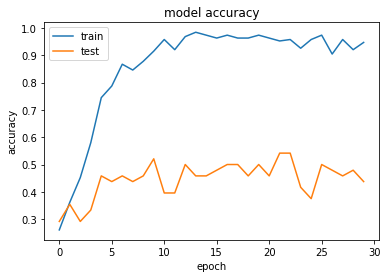

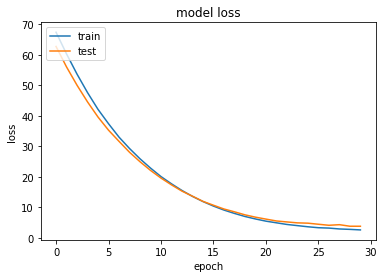

0.5102040816326531
person 6
(238, 199, 220)
Train on 190 samples, validate on 48 samples
Epoch 1/30
190/190 [==============================] - 14s 74ms/step - loss: 67.2305 - acc: 0.2474 - val_loss: 62.5812 - val_acc: 0.4375
Epoch 2/30
190/190 [==============================] - 3s 14ms/step - loss: 60.0294 - acc: 0.5263 - val_loss: 55.8958 - val_acc: 0.3958
Epoch 3/30
190/190 [==============================] - 3s 14ms/step - loss: 53.3762 - acc: 0.5737 - val_loss: 49.9118 - val_acc: 0.4792
Epoch 4/30
190/190 [==============================] - 3s 14ms/step - loss: 47.4254 - acc: 0.7211 - val_loss: 44.5070 - val_acc: 0.4583
Epoch 5/30
190/190 [==============================] - 3s 14ms/step - loss: 42.1304 - acc: 0.7842 - val_loss: 39.5253 - val_acc: 0.5208
Epoch 6/30
190/190 [==============================] - 3s 14ms/step - loss: 37.3018 - acc: 0.8421 - val_loss: 35.3416 - val_acc: 0.4167
Epoch 7/30
190/190 [==============================] - 3s 14ms/step - loss: 32.8774 - acc: 0.8895 - v

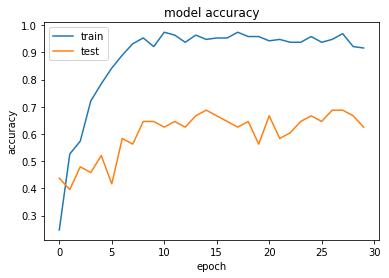

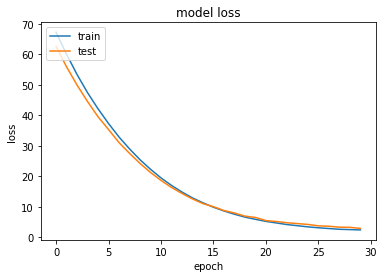

0.52
person 7
(232, 199, 220)
Train on 185 samples, validate on 47 samples
Epoch 1/30
185/185 [==============================] - 16s 85ms/step - loss: 67.4034 - acc: 0.2432 - val_loss: 62.7764 - val_acc: 0.3617
Epoch 2/30
185/185 [==============================] - 3s 14ms/step - loss: 60.3844 - acc: 0.4649 - val_loss: 56.3391 - val_acc: 0.4468
Epoch 3/30
185/185 [==============================] - 3s 14ms/step - loss: 53.8616 - acc: 0.6703 - val_loss: 50.3760 - val_acc: 0.4255
Epoch 4/30
185/185 [==============================] - 3s 14ms/step - loss: 47.8923 - acc: 0.7135 - val_loss: 44.9974 - val_acc: 0.5106
Epoch 5/30
185/185 [==============================] - 3s 14ms/step - loss: 42.5595 - acc: 0.8162 - val_loss: 40.0944 - val_acc: 0.4681
Epoch 6/30
185/185 [==============================] - 3s 14ms/step - loss: 37.7490 - acc: 0.8649 - val_loss: 35.6896 - val_acc: 0.5319
Epoch 7/30
185/185 [==============================] - 3s 15ms/step - loss: 33.3618 - acc: 0.8865 - val_loss: 31.74

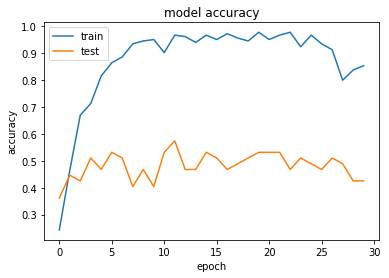

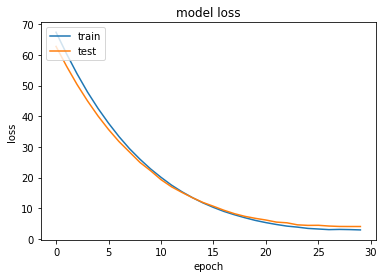

0.54
person 8
(231, 199, 220)
Train on 184 samples, validate on 47 samples
Epoch 1/30
184/184 [==============================] - 16s 86ms/step - loss: 67.5121 - acc: 0.2826 - val_loss: 63.0876 - val_acc: 0.4255
Epoch 2/30
184/184 [==============================] - 3s 15ms/step - loss: 60.6312 - acc: 0.5598 - val_loss: 56.6002 - val_acc: 0.4255
Epoch 3/30
184/184 [==============================] - 3s 15ms/step - loss: 54.2140 - acc: 0.6413 - val_loss: 50.9346 - val_acc: 0.3404
Epoch 4/30
184/184 [==============================] - 3s 14ms/step - loss: 48.3571 - acc: 0.7609 - val_loss: 45.5163 - val_acc: 0.5319
Epoch 5/30
184/184 [==============================] - 3s 14ms/step - loss: 43.0558 - acc: 0.8152 - val_loss: 40.5319 - val_acc: 0.4681
Epoch 6/30
184/184 [==============================] - 3s 15ms/step - loss: 38.2208 - acc: 0.8859 - val_loss: 36.2248 - val_acc: 0.5319
Epoch 7/30
184/184 [==============================] - 3s 15ms/step - loss: 33.9177 - acc: 0.8967 - val_loss: 32.08

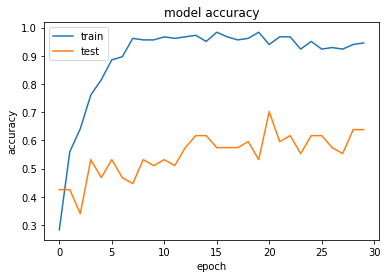

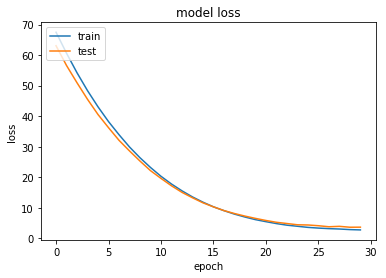

0.574468085106383


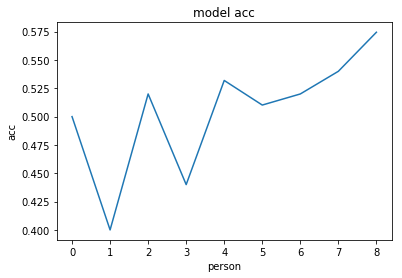

In [8]:
from keras.regularizers import l2

X_test_valid = np.load("X_test.npy")
y_test_valid = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")



def init_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(128,return_sequences=True,input_shape = input_shape,kernel_regularizer=regularizers.l2(0.05),recurrent_dropout=0.5)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(128,return_sequences=True,kernel_regularizer=regularizers.l2(0.05),recurrent_dropout=0.5)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(32, kernel_regularizer=regularizers.l2(0.05)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4,activation='softmax'))
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)   
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    return model

    

# Sliding windows on original data
window_length = 10
hop_length = 5
n_windows =(1000-window_length) // hop_length + 1 

print("windows number:", n_windows)


acc_array = []
for index in range(9):
    print("person",index)
    x_train = get_sharded_data(X_train_valid[:,:22,:],person_train_valid,index).astype('float32')
    x_test = get_sharded_data(X_test_valid[:,:22,:],person_test,index).astype('float32')
    y_train = get_sharded_data(y_train_valid,person_train_valid,index)
    y_test = get_sharded_data(y_test_valid,person_test,index)
    x_train = sliding(x_train)
    x_test = sliding(x_test)
    acc = RNN(x_train,y_train,x_test,y_test)
    acc_array.append(acc)

plt.plot(acc_array)
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('person')
plt.show()


In [10]:
print(np.mean(acc_array))

0.5040652289284507


## Train all Test all

windows number: 199
(2115, 199, 220)
Train on 1692 samples, validate on 423 samples
Epoch 1/30
1692/1692 [==============================] - 16s 9ms/step - loss: 7.9791 - acc: 0.2790 - val_loss: 6.4136 - val_acc: 0.3121
Epoch 2/30
1692/1692 [==============================] - 12s 7ms/step - loss: 5.2952 - acc: 0.3428 - val_loss: 4.4145 - val_acc: 0.3191
Epoch 3/30
1692/1692 [==============================] - 13s 7ms/step - loss: 3.8900 - acc: 0.3901 - val_loss: 3.4610 - val_acc: 0.3641
Epoch 4/30
1692/1692 [==============================] - 13s 8ms/step - loss: 3.0907 - acc: 0.4309 - val_loss: 2.9246 - val_acc: 0.3759
Epoch 5/30
1692/1692 [==============================] - 13s 8ms/step - loss: 2.6767 - acc: 0.4734 - val_loss: 2.5549 - val_acc: 0.4586
Epoch 6/30
1692/1692 [==============================] - 12s 7ms/step - loss: 2.3560 - acc: 0.5053 - val_loss: 2.3387 - val_acc: 0.4728
Epoch 7/30
1692/1692 [==============================] - 12s 7ms/step - loss: 2.1811 - acc: 0.5195 - val_lo

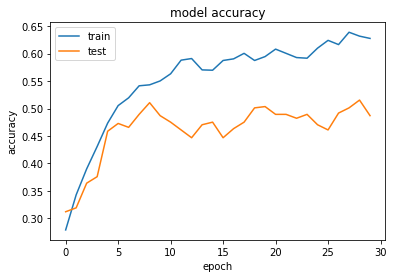

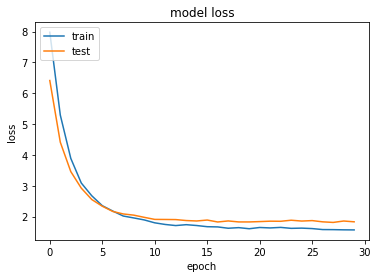

0.4650112866817156


In [9]:

def train(model,x_train,y_train,x_test,y_test):
    history = model.fit(x_train,y_train,batch_size=50,epochs=30,shuffle=True,validation_split=0.2)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return model
    
def predict(model,x_test,y_test):
    y_pred = model.predict(x_test)
    confusion_matrix = np.zeros((4, 4))
    accuracy = 0
    for i in range(y_pred.shape[0]):
        label_true = np.argmax(y_test[i])
        label_pred = np.argmax(y_pred[i])
        confusion_matrix[label_true, label_pred] += 1
        if label_true == label_pred:
            accuracy += 1
    accuracy /= x_test.shape[0]
    return accuracy,confusion_matrix



# Sliding windows on original data
window_length = 10
hop_length = 5
n_windows =(1000-window_length) // hop_length + 1 

print("windows number:", n_windows)

def sliding(data): #by default data's dimesnion is 3
    data_new = np.zeros((data.shape[0],n_windows,window_length*22)) #local variable
    for i in range(data.shape[0]):
        raw = data[i].transpose(1,0)
        for j in range(n_windows):
            data_new[i,j] = raw[j*hop_length:j*hop_length+window_length].flatten()
    return data_new



def RNN(x_train,y_train,x_test,y_test):
    train_example = x_train
    test_example = x_test
    train_target = keras.utils.to_categorical(y_train-769, 4)
    test_target = keras.utils.to_categorical(y_test-769, 4)
    print(train_example.shape)
    model = init_model(train_example[0].shape)
    model = train(model,train_example,train_target,test_example,test_target)
    acc,c_matrix = predict(model,test_example,test_target)
    print(acc)
    return acc


def init_model(input_shape):
    model = Sequential()
    model.add(LSTM(64,return_sequences=True,input_shape = input_shape,kernel_regularizer=regularizers.l2(0.02),recurrent_dropout=0.5))
    model.add(Dropout(0.5))
    model.add(LSTM(64,return_sequences=True,kernel_regularizer=regularizers.l2(0.02),recurrent_dropout=0.5))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(32, kernel_regularizer=regularizers.l2(0.02)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4,activation='softmax'))
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)   
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    return model


x_train = X_train_valid[:,:22,:].astype('float32')
x_test = X_test_valid[:,:22,:].astype('float32')
y_train = y_train_valid
y_test = y_test_valid
x_train = sliding(x_train)
x_test = sliding(x_test)
acc = RNN(x_train,y_train,x_test,y_test)

## Train one Test all

windows number: 199
person 0
Train on 189 samples, validate on 48 samples
Epoch 1/30
189/189 [==============================] - 9s 46ms/step - loss: 44.2213 - acc: 0.2910 - val_loss: 41.9603 - val_acc: 0.3750
Epoch 2/30
189/189 [==============================] - 2s 10ms/step - loss: 40.6171 - acc: 0.4762 - val_loss: 38.6406 - val_acc: 0.3333
Epoch 3/30
189/189 [==============================] - 2s 10ms/step - loss: 37.2227 - acc: 0.5397 - val_loss: 35.5127 - val_acc: 0.3542
Epoch 4/30
189/189 [==============================] - 2s 10ms/step - loss: 33.9494 - acc: 0.6190 - val_loss: 32.5062 - val_acc: 0.3750
Epoch 5/30
189/189 [==============================] - 2s 10ms/step - loss: 30.9738 - acc: 0.7196 - val_loss: 29.7733 - val_acc: 0.4583
Epoch 6/30
189/189 [==============================] - 2s 11ms/step - loss: 28.2148 - acc: 0.7619 - val_loss: 27.2099 - val_acc: 0.5000
Epoch 7/30
189/189 [==============================] - 2s 10ms/step - loss: 25.6323 - acc: 0.8677 - val_loss: 24.9286

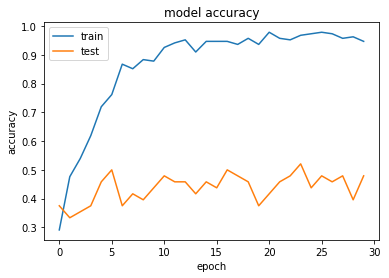

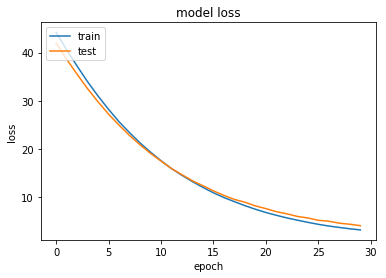

0.3792325056433409


0.3792325056433409

In [13]:
from keras.regularizers import l2


def init_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(64,return_sequences=True,input_shape = input_shape,kernel_regularizer=regularizers.l2(0.05),recurrent_dropout=0.5)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(64,return_sequences=True,kernel_regularizer=regularizers.l2(0.05),recurrent_dropout=0.5)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(32, kernel_regularizer=regularizers.l2(0.05)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4,activation='softmax'))
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)   
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    return model

    
# Sliding windows on original data
window_length = 10
hop_length = 5
n_windows =(1000-window_length) // hop_length + 1 

print("windows number:", n_windows)


index = 0
print("person",index)
x_train = get_sharded_data(X_train_valid[:,:22,:],person_train_valid,index).astype('float32')
x_test = get_sharded_data(x_test[:,:22,:],person_train_valid,index).astype('float32')

y_train = get_sharded_data(y_train_valid,person_train_valid,index)
y_test = y_test_valid
x_train = sliding(x_train)
x_test = sliding(x_test)
RNN(x_train,y_train,x_test,y_test)



windows number: 159
person 0
Train on 189 samples, validate on 48 samples
Epoch 1/30
189/189 [==============================] - 9s 48ms/step - loss: 44.3169 - acc: 0.2540 - val_loss: 42.0370 - val_acc: 0.3125
Epoch 2/30
189/189 [==============================] - 2s 8ms/step - loss: 40.6919 - acc: 0.4233 - val_loss: 38.6296 - val_acc: 0.3125
Epoch 3/30
189/189 [==============================] - 1s 8ms/step - loss: 37.2136 - acc: 0.5503 - val_loss: 35.4816 - val_acc: 0.3125
Epoch 4/30
189/189 [==============================] - 1s 8ms/step - loss: 34.0628 - acc: 0.5291 - val_loss: 32.5837 - val_acc: 0.2708
Epoch 5/30
189/189 [==============================] - 1s 8ms/step - loss: 30.9920 - acc: 0.7302 - val_loss: 29.8516 - val_acc: 0.3542
Epoch 6/30
189/189 [==============================] - 2s 8ms/step - loss: 28.3011 - acc: 0.7937 - val_loss: 27.3910 - val_acc: 0.2917
Epoch 7/30
189/189 [==============================] - 1s 8ms/step - loss: 25.7321 - acc: 0.8254 - val_loss: 25.0487 - val

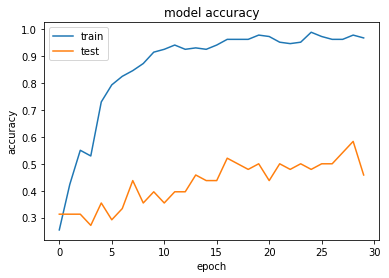

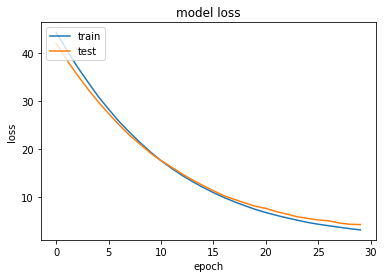

0.44


0.44

In [19]:
from keras.regularizers import l2

X_test_valid = np.load("X_test.npy")
y_test_valid = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")


def get_sharded_data(data, indices_arr, indicator):
    indices = [i for i,x in enumerate(indices_arr) if x == indicator]
    return data[indices]

def init_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(64,return_sequences=True,input_shape = input_shape,kernel_regularizer=regularizers.l2(0.05),recurrent_dropout=0.5)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(64,return_sequences=True,kernel_regularizer=regularizers.l2(0.05),recurrent_dropout=0.5)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(32, kernel_regularizer=regularizers.l2(0.05)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4,activation='softmax'))
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)   
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    return model

def train(model,x_train,y_train,x_test,y_test):
    history = model.fit(x_train,y_train,batch_size=50,epochs=30,shuffle=True,validation_split=0.2)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return model
    
def predict(model,x_test,y_test):
    y_pred = model.predict(x_test)
    confusion_matrix = np.zeros((4, 4))
    accuracy = 0
    for i in range(y_pred.shape[0]):
        label_true = np.argmax(y_test[i])
        label_pred = np.argmax(y_pred[i])
        confusion_matrix[label_true, label_pred] += 1
        if label_true == label_pred:
            accuracy += 1
    accuracy /= x_test.shape[0]
    return accuracy,confusion_matrix



# Sliding windows on original data
window_length = 10
hop_length = 5
n_windows =(800-window_length) // hop_length + 1 

print("windows number:", n_windows)

def sliding(data): #by default data's dimesnion is 3
    data_new = np.zeros((data.shape[0],n_windows,window_length*22)) #local variable
    for i in range(data.shape[0]):
        raw = data[i].transpose(1,0)
        for j in range(n_windows):
            data_new[i,j] = raw[j*hop_length:j*hop_length+window_length].flatten()
    return data_new



def RNN(x_train,y_train,x_test,y_test):
    train_example = x_train
    test_example = x_test
    train_target = keras.utils.to_categorical(y_train-769, 4)
    test_target = keras.utils.to_categorical(y_test-769, 4)
    
    model = init_model(train_example[0].shape)
    model = train(model,train_example,train_target,test_example,test_target)
    acc,c_matrix = predict(model,test_example,test_target)
    print(acc)
    return acc


# acc = RNN(x_train,y_train,x_test,y_test)

acc_array = []

index = 0
print("person",index)

x_train = get_sharded_data(X_train_valid[:,:22,:800],person_train_valid,0).astype('float32')
x_test = get_sharded_data(X_test_valid[:,:22,:800],person_test,0).astype('float32')
y_train = get_sharded_data(y_train_valid,person_train_valid,0)
y_test = get_sharded_data(y_test_valid,person_test,0)
x_train = sliding(x_train)
x_test = sliding(x_test)
RNN(x_train,y_train,x_test,y_test)



In [30]:
print(np.mean(acc_array))

0.34474260626236314


# Simple RNN Model

## Train One Test One for All People

windows number: 199
person 0
(237, 22, 1000)
Train on 189 samples, validate on 48 samples
Epoch 1/30
189/189 [==============================] - 8s 42ms/step - loss: 21.5044 - acc: 0.2751 - val_loss: 20.4108 - val_acc: 0.2292
Epoch 2/30
189/189 [==============================] - 0s 899us/step - loss: 19.7815 - acc: 0.4444 - val_loss: 19.1787 - val_acc: 0.2708
Epoch 3/30
189/189 [==============================] - 0s 904us/step - loss: 18.3647 - acc: 0.5767 - val_loss: 18.0143 - val_acc: 0.2708
Epoch 4/30
189/189 [==============================] - 0s 873us/step - loss: 17.1140 - acc: 0.6190 - val_loss: 16.9181 - val_acc: 0.2917
Epoch 5/30
189/189 [==============================] - 0s 911us/step - loss: 15.9608 - acc: 0.6614 - val_loss: 15.8341 - val_acc: 0.3333
Epoch 6/30
189/189 [==============================] - 0s 865us/step - loss: 14.8126 - acc: 0.7196 - val_loss: 14.8139 - val_acc: 0.3333
Epoch 7/30
189/189 [==============================] - 0s 859us/step - loss: 13.7933 - acc: 0.71

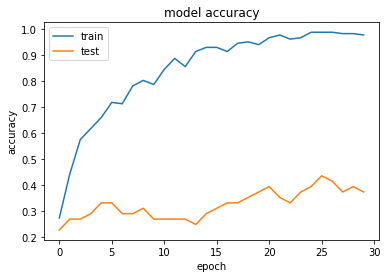

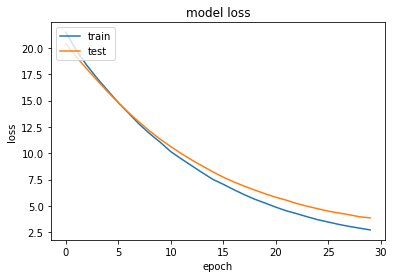

0.38
person 1
(236, 22, 1000)
Train on 188 samples, validate on 48 samples
Epoch 1/30
188/188 [==============================] - 8s 43ms/step - loss: 21.4395 - acc: 0.2713 - val_loss: 20.3558 - val_acc: 0.2917
Epoch 2/30
188/188 [==============================] - 0s 842us/step - loss: 19.7161 - acc: 0.4574 - val_loss: 19.1419 - val_acc: 0.2708
Epoch 3/30
188/188 [==============================] - 0s 823us/step - loss: 18.2728 - acc: 0.5160 - val_loss: 17.9870 - val_acc: 0.2708
Epoch 4/30
188/188 [==============================] - 0s 804us/step - loss: 17.0676 - acc: 0.5638 - val_loss: 16.8955 - val_acc: 0.2083
Epoch 5/30
188/188 [==============================] - 0s 827us/step - loss: 15.7824 - acc: 0.7128 - val_loss: 15.8205 - val_acc: 0.1875
Epoch 6/30
188/188 [==============================] - 0s 902us/step - loss: 14.5965 - acc: 0.8085 - val_loss: 14.7605 - val_acc: 0.2083
Epoch 7/30
188/188 [==============================] - 0s 883us/step - loss: 13.5400 - acc: 0.8191 - val_loss: 

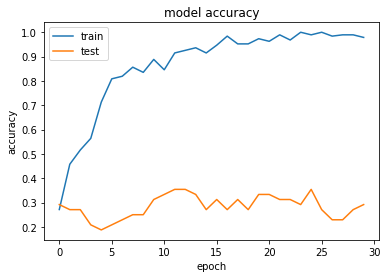

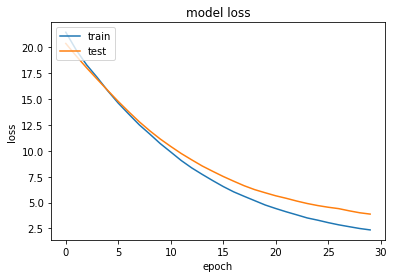

0.32
person 2
(236, 22, 1000)
Train on 188 samples, validate on 48 samples
Epoch 1/30
188/188 [==============================] - 9s 46ms/step - loss: 21.4549 - acc: 0.2074 - val_loss: 20.2961 - val_acc: 0.2917
Epoch 2/30
188/188 [==============================] - 0s 856us/step - loss: 19.7999 - acc: 0.4096 - val_loss: 19.0709 - val_acc: 0.2917
Epoch 3/30
188/188 [==============================] - 0s 856us/step - loss: 18.4548 - acc: 0.5213 - val_loss: 17.8992 - val_acc: 0.3125
Epoch 4/30
188/188 [==============================] - 0s 845us/step - loss: 17.2248 - acc: 0.5372 - val_loss: 16.7857 - val_acc: 0.3125
Epoch 5/30
188/188 [==============================] - 0s 840us/step - loss: 16.1256 - acc: 0.5904 - val_loss: 15.7324 - val_acc: 0.3333
Epoch 6/30
188/188 [==============================] - 0s 954us/step - loss: 14.9213 - acc: 0.6968 - val_loss: 14.7545 - val_acc: 0.3750
Epoch 7/30
188/188 [==============================] - 0s 908us/step - loss: 13.9196 - acc: 0.7606 - val_loss: 

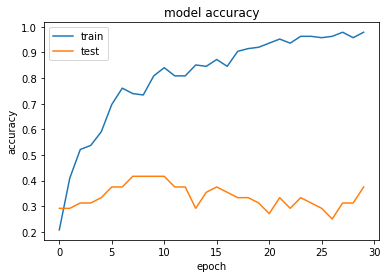

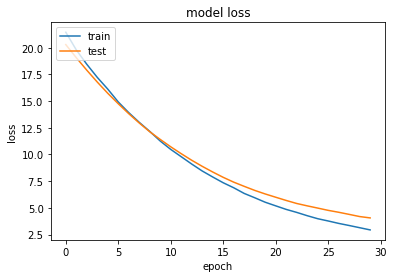

0.3
person 3
(234, 22, 1000)
Train on 187 samples, validate on 47 samples
Epoch 1/30
187/187 [==============================] - 9s 47ms/step - loss: 21.4022 - acc: 0.2674 - val_loss: 20.3403 - val_acc: 0.2979
Epoch 2/30
187/187 [==============================] - 0s 881us/step - loss: 19.7147 - acc: 0.4011 - val_loss: 19.0226 - val_acc: 0.3191
Epoch 3/30
187/187 [==============================] - 0s 828us/step - loss: 18.2593 - acc: 0.5187 - val_loss: 17.8037 - val_acc: 0.3191
Epoch 4/30
187/187 [==============================] - 0s 855us/step - loss: 16.9224 - acc: 0.6096 - val_loss: 16.6762 - val_acc: 0.2979
Epoch 5/30
187/187 [==============================] - 0s 864us/step - loss: 15.7409 - acc: 0.6150 - val_loss: 15.5898 - val_acc: 0.3191
Epoch 6/30
187/187 [==============================] - 0s 854us/step - loss: 14.5613 - acc: 0.7005 - val_loss: 14.5399 - val_acc: 0.3404
Epoch 7/30
187/187 [==============================] - 0s 848us/step - loss: 13.5500 - acc: 0.7005 - val_loss: 1

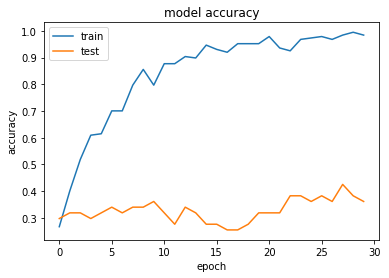

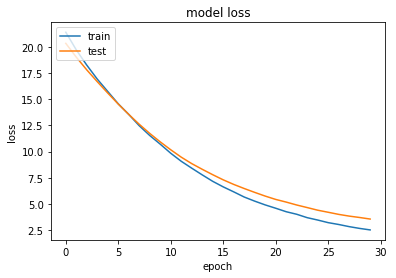

0.48
person 4
(235, 22, 1000)
Train on 188 samples, validate on 47 samples
Epoch 1/30
188/188 [==============================] - 9s 47ms/step - loss: 21.6332 - acc: 0.2447 - val_loss: 20.5618 - val_acc: 0.2340
Epoch 2/30
188/188 [==============================] - 0s 837us/step - loss: 19.9292 - acc: 0.4309 - val_loss: 19.3004 - val_acc: 0.2553
Epoch 3/30
188/188 [==============================] - 0s 850us/step - loss: 18.4520 - acc: 0.4840 - val_loss: 18.0385 - val_acc: 0.2979
Epoch 4/30
188/188 [==============================] - 0s 845us/step - loss: 17.1432 - acc: 0.5851 - val_loss: 16.8202 - val_acc: 0.3617
Epoch 5/30
188/188 [==============================] - 0s 832us/step - loss: 15.8915 - acc: 0.6596 - val_loss: 15.7268 - val_acc: 0.4043
Epoch 6/30
188/188 [==============================] - 0s 843us/step - loss: 14.7499 - acc: 0.6915 - val_loss: 14.7018 - val_acc: 0.3617
Epoch 7/30
188/188 [==============================] - 0s 831us/step - loss: 13.6518 - acc: 0.7606 - val_loss: 

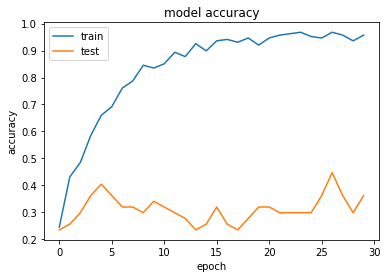

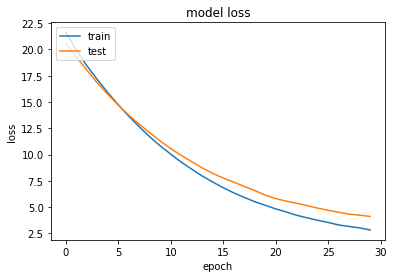

0.3191489361702128
person 5
(236, 22, 1000)
Train on 188 samples, validate on 48 samples
Epoch 1/30
188/188 [==============================] - 9s 47ms/step - loss: 21.4664 - acc: 0.2340 - val_loss: 20.2787 - val_acc: 0.3750
Epoch 2/30
188/188 [==============================] - 0s 836us/step - loss: 19.8503 - acc: 0.3511 - val_loss: 19.0802 - val_acc: 0.3333
Epoch 3/30
188/188 [==============================] - 0s 903us/step - loss: 18.5346 - acc: 0.4894 - val_loss: 17.9957 - val_acc: 0.3333
Epoch 4/30
188/188 [==============================] - 0s 878us/step - loss: 17.3659 - acc: 0.5691 - val_loss: 16.9032 - val_acc: 0.3958
Epoch 5/30
188/188 [==============================] - 0s 854us/step - loss: 16.1276 - acc: 0.6702 - val_loss: 15.8892 - val_acc: 0.4375
Epoch 6/30
188/188 [==============================] - 0s 876us/step - loss: 15.1005 - acc: 0.7500 - val_loss: 14.9042 - val_acc: 0.4375
Epoch 7/30
188/188 [==============================] - 0s 931us/step - loss: 14.0632 - acc: 0.766

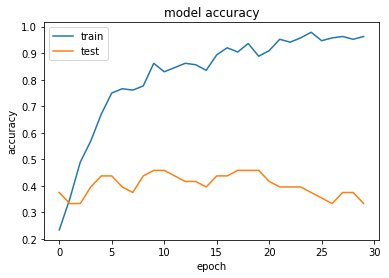

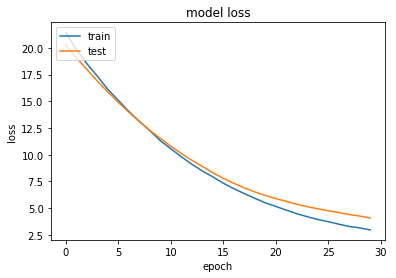

0.3469387755102041
person 6
(238, 22, 1000)
Train on 190 samples, validate on 48 samples
Epoch 1/30
190/190 [==============================] - 9s 48ms/step - loss: 21.4390 - acc: 0.2368 - val_loss: 20.2060 - val_acc: 0.3542
Epoch 2/30
190/190 [==============================] - 0s 882us/step - loss: 19.7501 - acc: 0.3947 - val_loss: 19.0290 - val_acc: 0.3333
Epoch 3/30
190/190 [==============================] - 0s 871us/step - loss: 18.3988 - acc: 0.4579 - val_loss: 17.8505 - val_acc: 0.3333
Epoch 4/30
190/190 [==============================] - 0s 869us/step - loss: 17.1002 - acc: 0.6053 - val_loss: 16.7257 - val_acc: 0.3750
Epoch 5/30
190/190 [==============================] - 0s 946us/step - loss: 15.9034 - acc: 0.6368 - val_loss: 15.6572 - val_acc: 0.3750
Epoch 6/30
190/190 [==============================] - 0s 1ms/step - loss: 14.8162 - acc: 0.6737 - val_loss: 14.6272 - val_acc: 0.3958
Epoch 7/30
190/190 [==============================] - 0s 996us/step - loss: 13.7532 - acc: 0.7105 

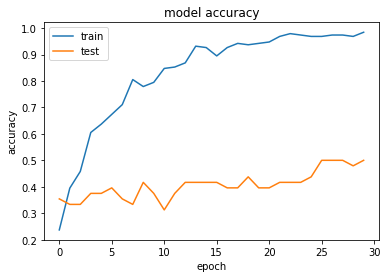

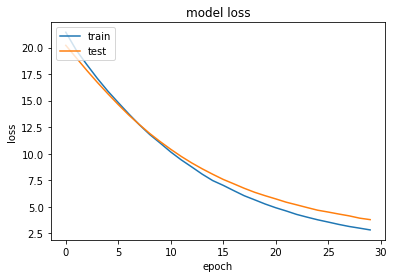

0.42
person 7
(232, 22, 1000)
Train on 185 samples, validate on 47 samples
Epoch 1/30
185/185 [==============================] - 9s 50ms/step - loss: 21.5612 - acc: 0.2649 - val_loss: 20.4827 - val_acc: 0.2553
Epoch 2/30
185/185 [==============================] - 0s 879us/step - loss: 19.9176 - acc: 0.4216 - val_loss: 19.3739 - val_acc: 0.2979
Epoch 3/30
185/185 [==============================] - 0s 860us/step - loss: 18.7506 - acc: 0.4973 - val_loss: 18.2914 - val_acc: 0.3191
Epoch 4/30
185/185 [==============================] - 0s 869us/step - loss: 17.5576 - acc: 0.5730 - val_loss: 17.2837 - val_acc: 0.3191
Epoch 5/30
185/185 [==============================] - 0s 844us/step - loss: 16.4728 - acc: 0.6595 - val_loss: 16.3323 - val_acc: 0.2979
Epoch 6/30
185/185 [==============================] - 0s 858us/step - loss: 15.4220 - acc: 0.6757 - val_loss: 15.3955 - val_acc: 0.2553
Epoch 7/30
185/185 [==============================] - 0s 848us/step - loss: 14.4797 - acc: 0.7189 - val_loss: 

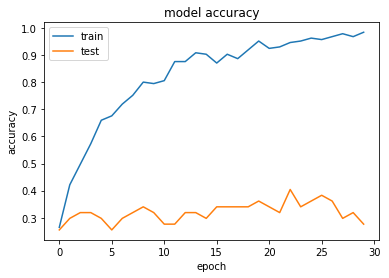

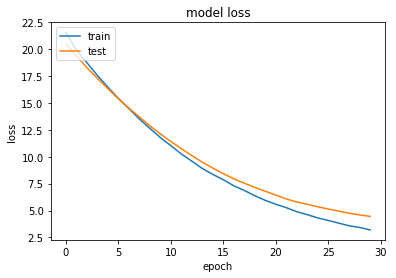

0.26
person 8
(231, 22, 1000)
Train on 184 samples, validate on 47 samples
Epoch 1/30
184/184 [==============================] - 10s 52ms/step - loss: 21.4985 - acc: 0.2826 - val_loss: 20.4884 - val_acc: 0.2340
Epoch 2/30
184/184 [==============================] - 0s 882us/step - loss: 19.8883 - acc: 0.3587 - val_loss: 19.3233 - val_acc: 0.2128
Epoch 3/30
184/184 [==============================] - 0s 887us/step - loss: 18.6803 - acc: 0.4565 - val_loss: 18.2887 - val_acc: 0.3191
Epoch 4/30
184/184 [==============================] - 0s 842us/step - loss: 17.5852 - acc: 0.5598 - val_loss: 17.3642 - val_acc: 0.2979
Epoch 5/30
184/184 [==============================] - 0s 849us/step - loss: 16.5167 - acc: 0.5924 - val_loss: 16.4286 - val_acc: 0.2979
Epoch 6/30
184/184 [==============================] - 0s 912us/step - loss: 15.5253 - acc: 0.6087 - val_loss: 15.5627 - val_acc: 0.2766
Epoch 7/30
184/184 [==============================] - 0s 883us/step - loss: 14.6169 - acc: 0.6630 - val_loss:

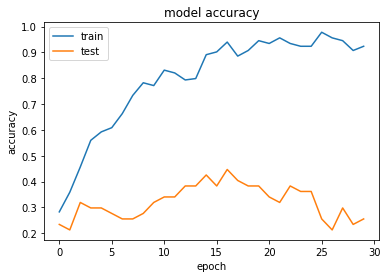

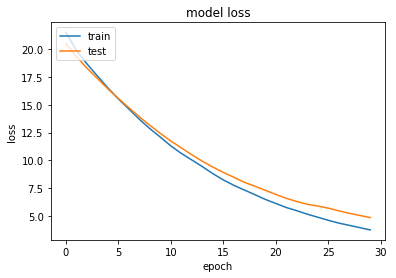

0.2765957446808511


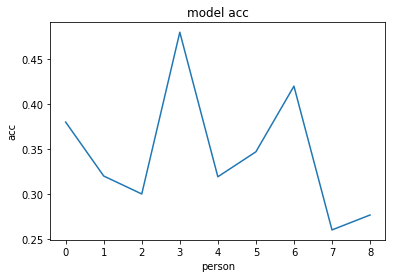

In [28]:
def init_model(input_shape):
    model = Sequential()
    model.add((LSTM(64,kernel_regularizer=regularizers.l2(0.05),recurrent_dropout=0.5)))
    model.add(Dropout(0.5))
    model.add(Dense(4,activation='softmax'))
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)   
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    return model




# Sliding windows on original data
window_length = 10
hop_length = 5
n_windows =(1000-window_length) // hop_length + 1 

print("windows number:", n_windows)

def sliding(data): #by default data's dimesnion is 3
    data_new = np.zeros((data.shape[0],n_windows,window_length*22)) #local variable
    for i in range(data.shape[0]):
        raw = data[i].transpose(1,0)
        for j in range(n_windows):
            data_new[i,j] = raw[j*hop_length:j*hop_length+window_length].flatten()
    return data_new




acc_array = []
for index in range(9):
    print("person",index)
    x_train = get_sharded_data(X_train_valid[:,:22,:],person_train_valid,index).astype('float32')
    x_test = get_sharded_data(X_test_valid[:,:22,:],person_test,index).astype('float32')
    y_train = get_sharded_data(y_train_valid,person_train_valid,index)
    y_test = get_sharded_data(y_test_valid,person_test,index)
#     x_train = sliding(x_train)
#     x_test = sliding(x_test)
    acc = RNN(x_train,y_train,x_test,y_test)
    acc_array.append(acc)

plt.plot(acc_array)
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('person')
plt.show()

## Train All Test All

(2115, 22, 1000)
Train on 1692 samples, validate on 423 samples
Epoch 1/30
1692/1692 [==============================] - 12s 7ms/step - loss: 17.4966 - acc: 0.2831 - val_loss: 13.8644 - val_acc: 0.2577
Epoch 2/30
1692/1692 [==============================] - 1s 782us/step - loss: 11.5670 - acc: 0.3735 - val_loss: 9.6632 - val_acc: 0.3144
Epoch 3/30
1692/1692 [==============================] - 1s 771us/step - loss: 8.1652 - acc: 0.4498 - val_loss: 7.1928 - val_acc: 0.2979
Epoch 4/30
1692/1692 [==============================] - 1s 774us/step - loss: 6.1307 - acc: 0.5059 - val_loss: 5.6885 - val_acc: 0.3121
Epoch 5/30
1692/1692 [==============================] - 1s 861us/step - loss: 4.9028 - acc: 0.5207 - val_loss: 4.7759 - val_acc: 0.2837
Epoch 6/30
1692/1692 [==============================] - 1s 797us/step - loss: 4.1385 - acc: 0.5408 - val_loss: 4.1735 - val_acc: 0.3050
Epoch 7/30
1692/1692 [==============================] - 1s 788us/step - loss: 3.5901 - acc: 0.5644 - val_loss: 3.7545 

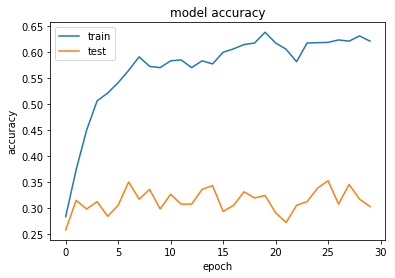

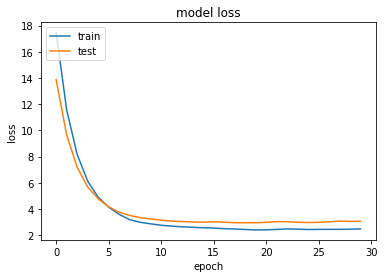

0.3340857787810384


In [31]:
x_train = X_train_valid[:,:22,:].astype('float32')
x_test = X_test_valid[:,:22,:].astype('float32')
y_train = y_train_valid
y_test = y_test_valid

acc = RNN(x_train,y_train,x_test,y_test)